In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Real or Sim?real
Which Quantum Computer?london
Number of qubits?3


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


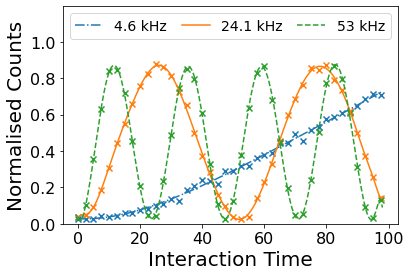

In [17]:
import cmath
import numpy as np
import matplotlib.pyplot as plt
import math
import unicodedata

if input("Real or Sim?").lower()=="real":
    backend = provider.get_backend('ibmq_'+input("Which Quantum Computer?"))
    data_points=40
    sim=0.4
else:
    backend = Aer.get_backend('qasm_simulator')
    data_points=200
    sim=2
# Create the circuit
n = int(input('Number of qubits?'))

def coupling(circuit,q1,q2,t,f,orientation):
    if orientation == 'z':
        #circuit.h(q1)
        circuit.rz(t*f/2,q1)
        circuit.cx(q1,q2)
    elif orientation == 'x':
        circuit.rx(t*f/2,q1)
        circuit.cx(q1,q2)
    elif orientation == 'y':
        circuit.ry(t*f/2,q1)
        circuit.cx(q1,q2)
    else:
        print('Invalid orientation')
    return circuit

def magnetic(circuit,q,t,f,orientation):
    if orientation == 'z':
        circuit.rz(t*f,q)
    elif orientation == 'x':
        circuit.rx(t*f,q)
    elif orientation == 'y':
        circuit.ry(t*f,q)
    else:
        print('Invalid orientation')
    return circuit

def wait(circuit,t):
    for i in range(0,t):
        circuit.i(range(0,n))
    return circuit

def pi_pulse(circuit,qubits):
    circuit.x(qubits)
    return circuit

def measure(qubits):
    circuit=QuantumCircuit(n,n)
    circuit.measure(qubits,qubits)
    return circuit

def make_function(t,u,E):
    function = (-4*t+u-3*E)**2/((2*t**2-E**2+u*E)**2+(4*t+3-u)**2)
    return function

style=['-.','-','--']

sensor = 1
emitter = 0
count=0
for freq in [4.6,24.1,53]:
    period = 0
    exp_period=[]
    circuits=[]
    freq1 = 50
    freq2 = 5
    freq3 = 25

    for t in range(0,data_points):
        t=t
        circuit = ''
        circuit=QuantumCircuit(n,n)
        circuit.h([0,1])
        coupling(circuit,0,1,t/data_points,freq,'z')

        pi_pulse(circuit,[0])

        circuit.h([0])
        circuit.rz(t/2/data_points*freq,0)

        pi_pulse(circuit,[1])
        coupling(circuit,0,1,t/2/data_points,freq,'z')
        circuit.h(1)

        circuits.append(circuit+measure([0,1,2]))
        exp_period.append(t/sim)



    # Execute the circuits
    shots = 1024
    job = execute(circuits, backend,
                  shots=shots, seed_simulator=8)
    result = job.result()


    # Plot
    data_000=[]
    data_001=[]
    data_010=[]
    data_100=[]
    data_011=[]
    data_101=[]
    data_110=[]
    data_111=[]
    data={}
    exp_error=[]
    target = []

    for exp_index in circuits:
        data = result.get_counts(exp_index)
        #print(data)
        try:
            p000 = data['000']/shots
        except KeyError:
            p000 = 0
        try:
            p001 = data['001']/shots
        except KeyError:
            p001 = 0
        try:
            p010 = data['010']/shots
        except KeyError:
            p010 = 0
        try:
            p100 = data['100']/shots
        except KeyError:
            p100 = 0
        try:
            p011 = data['011']/shots
        except KeyError:
            p011 = 0
        try:
            p101 = data['101']/shots
        except KeyError:
            p101 = 0
        try:
            p110 = data['110']/shots
        except KeyError:
            p110 = 0
        try:
            p111 = data['111']/shots
        except KeyError:
            p111 = 0
        data_000.append(p000)
        data_001.append(p001)
        data_010.append(p010)
        data_100.append(p100)
        data_011.append(p011)
        data_101.append(p101)
        data_110.append(p110)
        data_111.append(p111)
        exp_error.append(np.sqrt(p001*(1-p001)/shots))

    # Plot the results
    if count==0:
        polynomial = np.polyfit(exp_period, data_001, 4)
        Xs = [i/100 for i in range(0,math.ceil(max(exp_period))*100)]
        Ys = []
        for i in Xs:
            Y=0
            for a,j in enumerate(polynomial):
                Y+=j*i**(len(polynomial)-a-1)
            Ys.append(Y) 
        plt.scatter(exp_period, data_001, marker = 'x')
        plt.plot(Xs, Ys, label = str(freq)+' kHz', linestyle=style[count])  
    else:
        polynomial = np.polyfit(exp_period, data_001, 21)
        Xs = [i/100 for i in range(0,math.ceil(max(exp_period))*100)]
        Ys = []
        for i in Xs:
            Y=0
            for a,j in enumerate(polynomial):
                Y+=j*i**(len(polynomial)-a-1)
            Ys.append(Y) 
        plt.scatter(exp_period, data_001, marker = 'x')
        plt.plot(Xs,Ys, label = str(freq)+' kHz', linestyle=style[count])
    count+=1
    
            
        
plt.legend(fontsize=14, mode='expand', frameon="False", ncol=3, fancybox="False", loc="upper center")
plt.ylabel('Normalised Counts', fontsize=20)
plt.xlabel('Interaction Time', fontsize=20)
plt.ylim(0,1.195)
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()   



### 